In [4]:
import csv
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import functools

In [5]:
print(tf.__version__)

2.6.3


In [6]:
def read(filename, date_idx, date_parse, year=None, bucket=7):
    days_in_year = 365
    
    freq = {}
    if year != None:
         for period in range(0, int(days_in_year / bucket)):
            freq[period] = 0
        
    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)
        for row in csvreader:
            if row[date_idx] == '':
                continue
            
            t = time.strptime(row[date_idx], date_parse)
            if year == None:
                if not t.tm_year in freq:
                    freq[t.tm_year] = {}
                    for period in range(0, int(days_in_year / bucket)):
                        freq[t.tm_year][period] = 0
                
                if t.tm_yday < (days_in_year - 1):
                    freq[t.tm_year][int(t.tm_yday / bucket)] += 1
                    
            else:
                if t.tm_year == year and t.tm_yday < (days_in_year-1):
                    freq[int(t.tm_yday / bucket)] += 1
    
    return freq

In [7]:
def split_dataset(x_dataset, y_dataset, ratio):
    arr = np.arange(x_dataset.size)
    np.random.shuffle(arr)
    num_train = int(ratio * x_dataset.size)
    x_train = x_dataset[arr[0:num_train]]
    x_test = x_dataset[arr[num_train:x_dataset.size]]
    y_train = y_dataset[arr[0:num_train]]
    y_test = y_dataset[arr[num_train:x_dataset.size]]
    return x_train, x_test, y_train, y_test

In [8]:
freq = read('311.csv', 1, '%m/%d/%Y %H:%M:%S %p', 2014)

In [9]:
freq

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 11007,
 22: 40636,
 23: 42519,
 24: 43107,
 25: 42245,
 26: 38769,
 27: 42352,
 28: 41406,
 29: 39419,
 30: 36438,
 31: 39173,
 32: 37408,
 33: 37354,
 34: 27074,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0}

Num samples 52


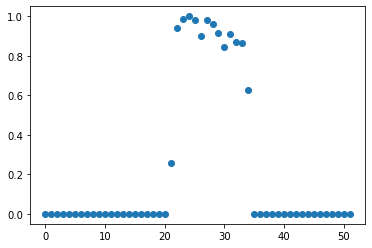

In [10]:
X_train = np.asarray(list(freq.keys()))
Y_train = np.asarray(list(freq.values()))
print("Num samples", str(len(X_train)))
maxY = np.max(Y_train)
nY_train = Y_train / np.max(Y_train)

plt.scatter(X_train, nY_train)
plt.show()

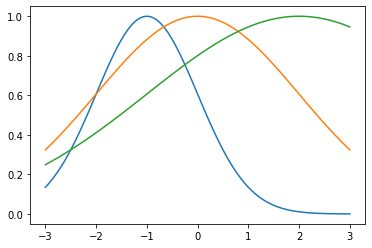

In [11]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
x_values = np.linspace(-3, 3, 120)
for mu, sig in [(-1, 1), (0, 2), (2, 3)]:
    plt.plot(x_values, gaussian(x_values, mu, sig))

plt.show()

In [12]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

import warnings
warnings.filterwarnings('ignore')

#learning_rate = 0.001
learning_rate = 1.5
training_epochs = 5000

X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

def model(X, mu, sig):
    return tf.exp(tf.div(tf.negative(tf.pow(tf.subtract(X, mu), 2.)), tf.multiply(2., tf.pow(sig, 2.))))

mu = tf.Variable(1., name="mu")
sig = tf.Variable(1., name="sig")
y_model = model(X, mu, sig)

In [13]:
cost = tf.square(Y-y_model)
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

sess= tf.compat.v1.Session()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(training_epochs):
    for(x, y) in zip(X_train, nY_train):
        sess.run(train_op, feed_dict={X:x, Y:y})
        
mu_val = sess.run(mu)
sig_val = sess.run(sig)

print(mu_val)
print(sig_val)

sess.close()

27.231413
4.9024706


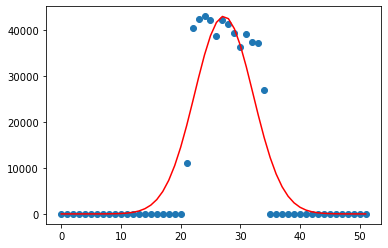

Prediction of week 35 21572.297356427585
Actual week 35 37354


In [14]:
plt.scatter(X_train, Y_train)
trY2 = maxY * (np.exp(-np.power(X_train - mu_val, 2.) / (2 * np.power(sig_val, 2.))))
plt.plot(X_train, trY2, 'r')
plt.show()
print("Prediction of week 35", trY2[33])
print("Actual week 35", Y_train[33])

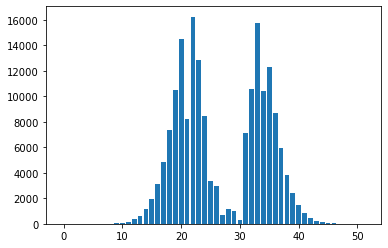

Average Error 208.08780826074533
Accuracy 0.9951727606128762


In [15]:
# plot the error
error = np.power(np.power(trY2 - Y_train, 2), 0.5)
plt.bar(X_train, error)
plt.show()

# compute the overall average error
avg_error = functools.reduce(lambda a,b: a+b, (trY2-Y_train))
avg_error = np.abs(avg_error) / len(X_train)
print("Average Error", avg_error)
acc = 1. - (avg_error / maxY)
print("Accuracy", acc)